In [6]:
import numpy as np
import matplotlib.pyplot as plt
# import mkl

# mkl.set_num_threads(2)
np.random.seed(1234)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [7]:
def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def as_matrix(vector):
    return np.reshape(vector, (-1, 1))

def one_hot_encode(labels):
    one_hot = zeros(labels.shape[0], np.max(labels) + 1) 
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot.astype(np.float32)

def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (examples[r, c] - ex_min) / (ex_max - ex_min)
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

### Activation functions

In [8]:
def relu(batch):
    return np.maximum(0.0, batch)

def relu_derivative(batch):
    return (batch > 0).astype(np.float32)

def softmax(batch):
    m = as_matrix(np.max(batch, axis=1))
    exponents = np.exp(batch - m)
    return exponents / as_matrix(np.sum(exponents, axis=1))

# MNIST dataset

/tmp/ipykernel_4155/1130723417.py:4: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))


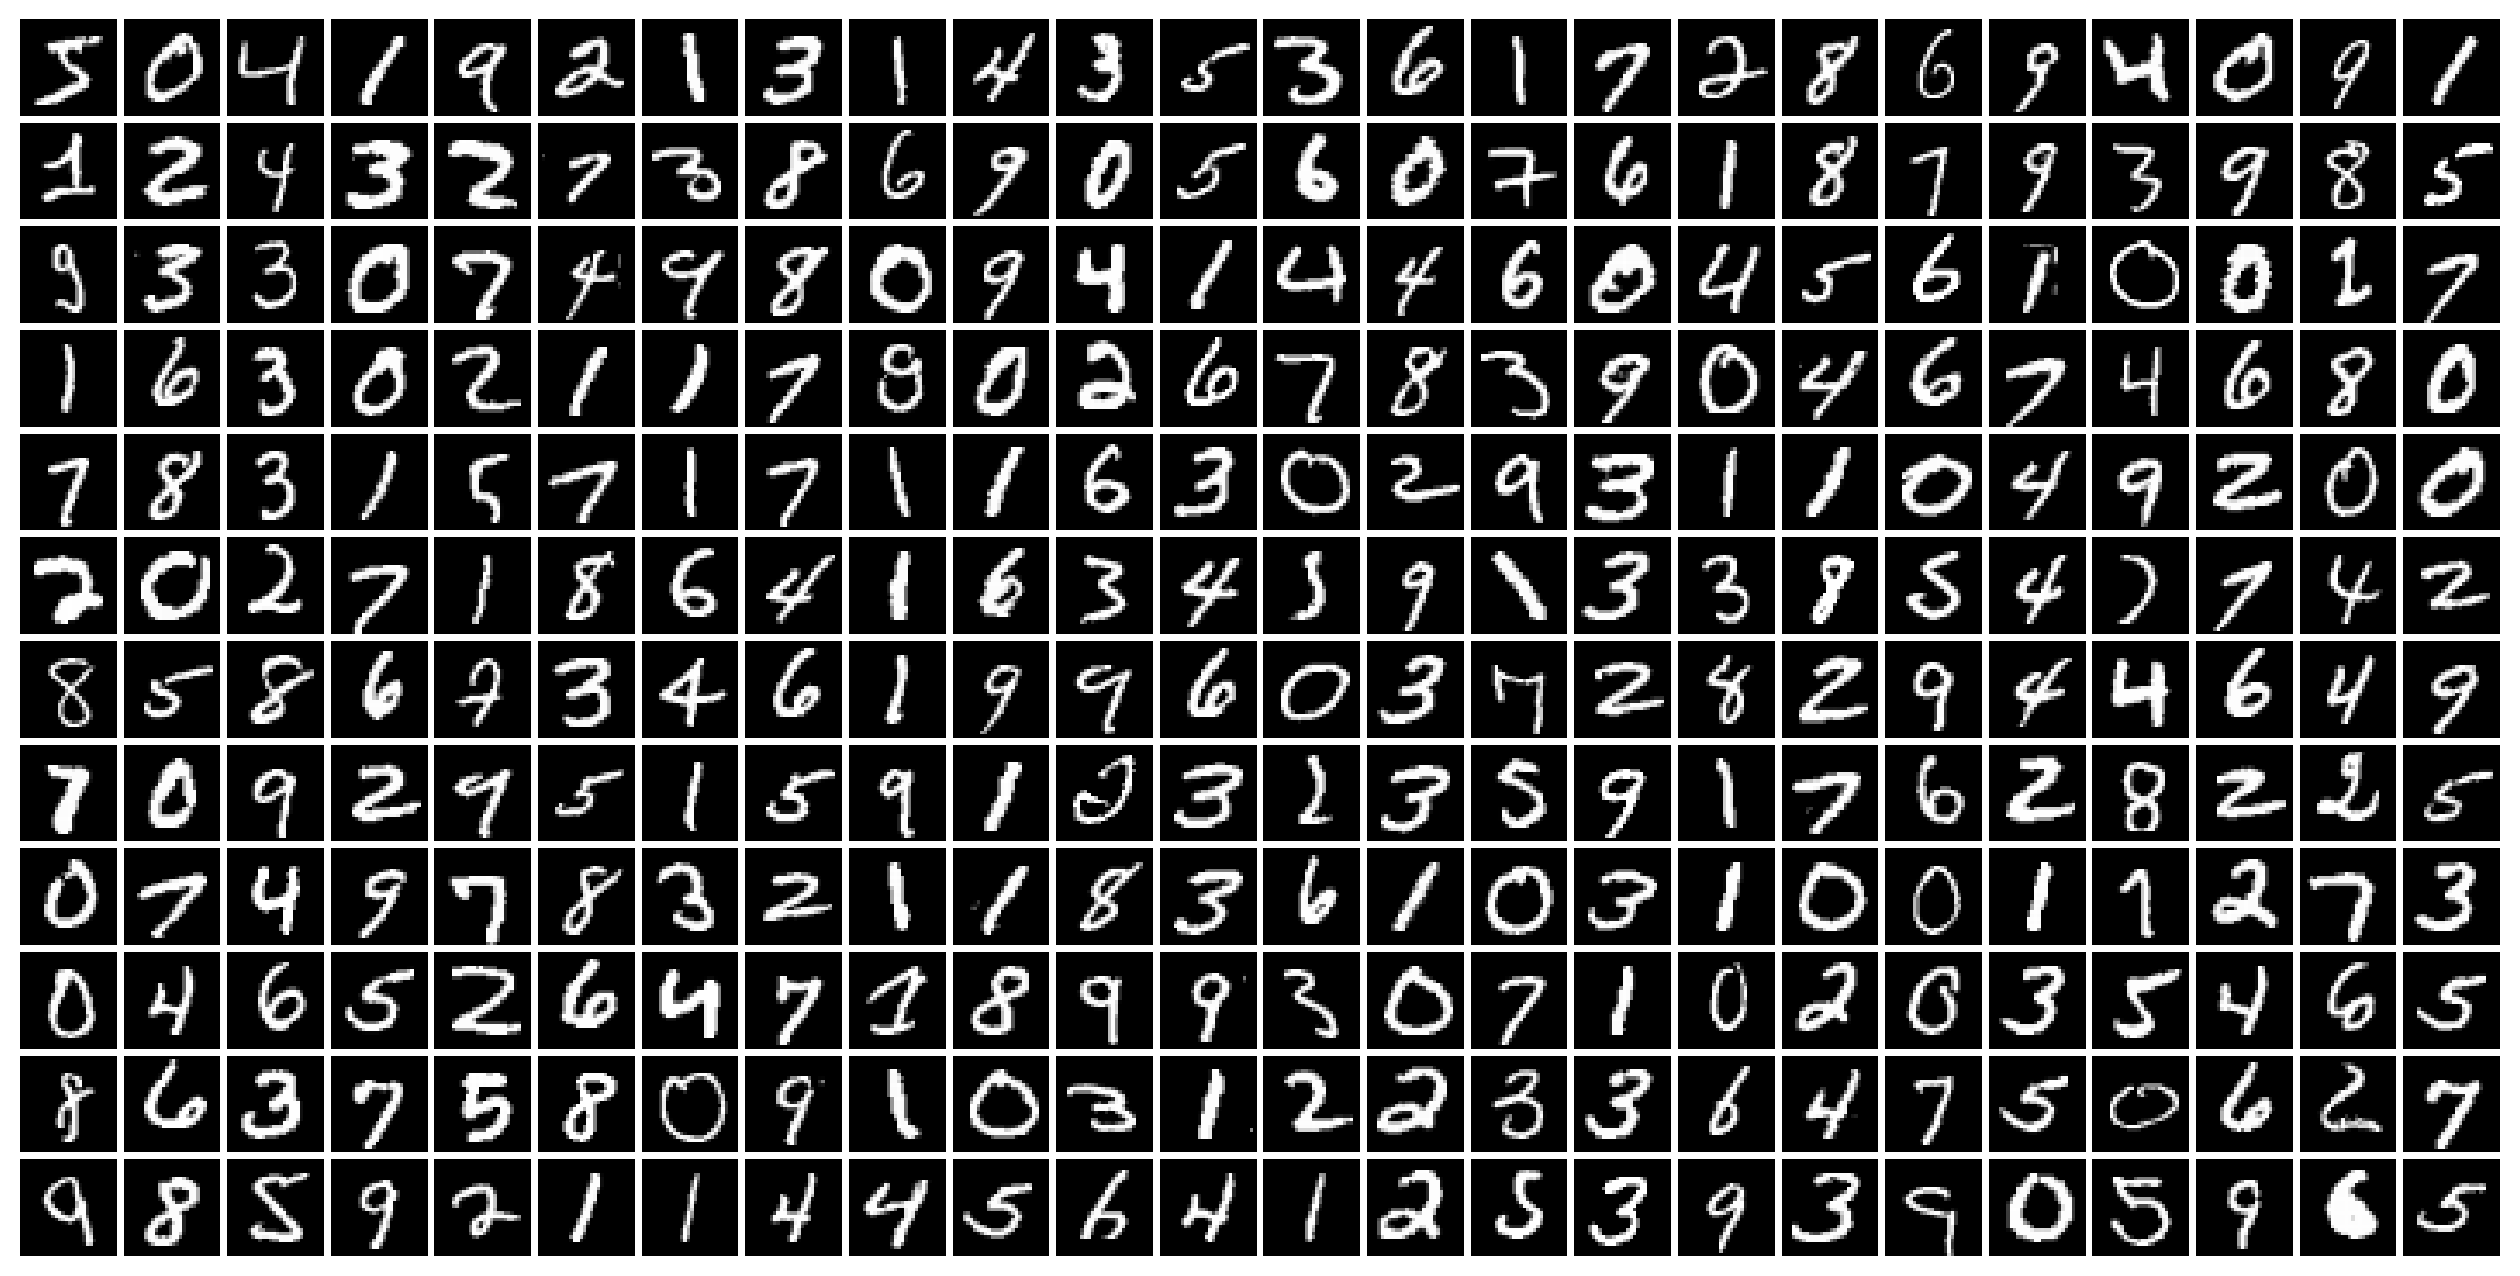

In [9]:
import mnists
mnist = mnists.MNIST()

digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(digits)

# Network layers

We define three types of layers: densely connected layer (```Dense```), convolutional layer (```Conv2D```) and non-linearity (```Nonlinear```). Each layer supports two operations:

- signal propagation: ```forward```
- error backpropagation: ```backward```

```backward``` operation backpropagates the delta and updates layer weights and biases.

Weights are initialized with "variance scaling" method (also known as "He initialization"). This initialization was proposed together with residual networks and is appropriate for networks with ReLU activations. Source: https://arxiv.org/pdf/1502.01852v1.pdf

**Note that in this lab we have separate vectors for biases.**

### Non-linearity

In [10]:
class Nonlinear:
    def __init__(self, activation_fun, d_activation_fun):
        self.activation_fun = activation_fun
        self.d_activation_fun = d_activation_fun
        
        self.visible = None
    
    def reset(self):
        pass
    
    def forward(self, batch):
        self.visible = batch
        return self.activation_fun(batch)
    
    def backward(self, deltas):
        return deltas * self.d_activation_fun(self.visible)

### Densly connected layer

Implement missing parts in the ```backward``` method. Remember that the biases are kept in a separate vector.

In [24]:
class Dense:
    def __init__(self, visible_size, hidden_size, learning_rate, momentum):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
                
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.reset()
    
    def reset(self):
        self.W = np.random.normal(scale=np.sqrt(2.0 / self.visible_size),
                                  size=(self.visible_size, self.hidden_size)).astype(np.float32)
        self.B = zeros(1, self.hidden_size)
        
        self.in_shape = None
        
        self.visible = None
        self.hidden  = None

        self.MW = zeros(self.visible_size, self.hidden_size)
        self.MB = zeros(1, self.hidden_size)
    
    def forward(self, batch):
        self.in_shape = batch.shape
        self.visible = np.reshape(batch, (batch.shape[0], -1))
        
        self.hidden = self.visible @ self.W + self.B
        return self.hidden
    
    def backward(self, deltas):
        observations_count = self.visible.shape[0]
        
        prev_deltas = deltas @ self.W.T
        prev_deltas = prev_deltas.reshape(self.in_shape)
        
        
        # raise NotImplementedError('Gradient calculation in Dense is not implemented.')
        
        # Calculate the gradient for the weights and biases. Store the result
        # in `grad_w` and `grad_b`, respectively.
        #
        # This is a standard densly connected layer, so take hints from the backprop
        # implementation in previous labs. Note, however, that we now have a separate
        # vector for biases. This means that you need to deduce an explicit equation
        # for the gradient with respect to the biases (consider how were the biases
        # updated in the previous backprop implementation).
        #
        # Inputs to the current layer are stored in `self.visible`
        # Deltas for the current layer are stored in `deltas`.
        
        # grad_w = ???
        # grad_b = ???
        grad_w = self.visible.T @ deltas
        grad_b = np.ones(*deltas[-1, :].T.shape) @ deltas[-1, :].T 
        
        grad_b = np.expand_dims(grad_b, axis=0)
        
        self.MW = self.momentum * self.MW - \
                  self.learning_rate / observations_count * grad_w
        self.MB = self.momentum * self.MB - \
                  self.learning_rate / observations_count * grad_b
        
        self.W += self.MW
        self.B += self.MB
        
        return prev_deltas

## Convolutional layers

We implement the convolution operation as a simple matrix multiplication. Essentially, convolution is a dot product between the kernel and the receptive fields (local regions of the input image). Therefore:
- We can rearrange the input volume into a matrix $\mathbf{X}$, in which each column is a receptive field reshaped to a vector. The number of columns in this matrix is equal to the number of receptive fields in an image multiplied by the number of input images (batch size).
- Next, we can reshape the convolution kernel into a vector. Note, however, that a convolutional layer has many kernels: the number of kernels is equal to the number of output channels. We can assemble these kernels into a matrix $\mathbf{K}$, in which each row is one kernel (reshaped to a vector).
- Once we have matrices $\mathbf{X}$ and $\mathbf{K}$, calculating the convolution is as simple as taking a matrix multiplication $\mathbf{KX}$.

A very important property of this implementation is that the convolution is expressed as a matrix multiplication. This is the same basic operation that is used in densely connected layers. This means that backpropagation equations from a simple MLPs also holds for this implementation of a convolutional layer. Matrix $\mathbf{X}$ is the equivalent of the visible layer and matrix $\mathbf{K}$ is the equivalent of the weight matrix.

Important notes:
- The rearrangements of the input volume into a matrix is implemented by ```im2col``` function.
- During backpropagation we need to perform an operation inverse to ```im2col```. Specifically, we need to “collapse” deltas from a matrix into a volume with shape equal to the shape of the input. This inverse operation is implemented by ```col2im``` function.
- Kernels in ```Conv2D``` are always kept as a matrix, where each row is a kernel for one output channel.
- Convolution layer has no activation function (or, equivalently, has an identify activation function). Nonlinear activations are implemented by a separate layer (```Nonlinear``` layer). Therefore, we can disregard activation function (and its derivative) when implementing error backpropagation in ```Conv2D```.
- We have a separate vector $\mathbf{B}$ for biases. Our expression for convolution is therefore: $\mathbf{KX} + \mathbf{B}$. Note that biases are shared between receptive fields (vector $\mathbf{B}$ is broadcasted to the shape of $\mathbf{KX}$). See implementation of ```Dense``` layer for hints about proper implementation of biases in forward/backward pass.

You can find more information about implementing convolution via ```im2col```/```col2im``` here:
* http://cs231n.stanford.edu/slides/2016/winter1516_lecture11.pdf
* http://cs231n.github.io/convolutional-networks/

### im2col and col2im

In [12]:
def col_indices(shape, kernel_size, strides):
    kh, kw = kernel_size
    sh, sw = strides
    
    n, c, h, w = shape
    
    col_extent = w - kw + 1
    row_extent = h - kh + 1
    
    batch_idx = np.arange(n)[:, None, None] * c * h * w
    
    start_idx = np.arange(kh)[None, :, None] * w + np.arange(kw)
    
    depth_idx = h * w * np.arange(c)
    start_idx = (depth_idx[None, :, None] + start_idx.ravel())
    start_idx = start_idx.reshape((-1, kh, kw))
    
    offset_idx = np.arange(row_extent)[None, :, None] * w + np.arange(col_extent)
    
    idx = (batch_idx + 
           start_idx.ravel()[None, :, None] + 
           offset_idx[:, ::sh, ::sw].ravel())
    
    return idx

def im2col(batch, kernel_size, strides, cached_indices=None):
    if cached_indices is not None and batch.shape[0] == cached_indices.shape[0]:
        idx = cached_indices
    else:
        idx = col_indices(batch.shape, kernel_size, strides)
    
    cols = np.take(batch, idx).transpose(1, 0, 2)
    cols = np.reshape(cols, (cols.shape[0], -1))
    return cols, idx

def col2im(shape, cols, kernel_size, strides, cached_indices=None):
    n, c, h, w = shape
    kh, kw = kernel_size
    
    if cached_indices is not None and cols.shape == cached_indices.shape:
        idx = cached_indices
    else:
        idx = col_indices(shape, kernel_size, strides).transpose(1, 0, 2).reshape(kh*kw*c, -1)
    
    im = zeros(*shape).reshape(-1)
    for idxs, vals in zip(idx, cols):
        im[idxs] += vals
    
    return im.reshape(*shape), idx

### 2D convolution

Implement missing parts in the ```forward``` and ```backward``` methods.  Remember that the biases are kept in a separate vector.

In [30]:
class Conv2D:
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 strides,
                 padding,
                 learning_rate,
                 momentum,
                 cache_col_indices=True):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        
        kh, kw = self.kernel_size
        self.klen = kh * kw * self.in_channels
        
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.cache_col_indices = cache_col_indices
                    
        self.reset()
    
    def reset(self):
        self.K = np.random.normal(scale=np.sqrt(2.0 / self.klen),
                                  size=(self.out_channels, self.klen)).astype(np.float32)
        
        self.B = zeros(self.out_channels, 1) + 1e-2 # Initialize biases to small positive values (for ReLU)
        
        self.padded_shape = None
        self.cols         = None
        
        self.i2c_col_indeces = None
        self.c2i_col_indeces = None
        
        self.MK = zeros(self.out_channels, self.klen)
        self.MB = zeros(self.out_channels, 1)
    
    def pad(self, batch):
        ph, pw = self.padding
        if ph == 0 and pw == 0:
            self.padded_shape = batch.shape
            return batch

        n, c, h, w = batch.shape        
        batch_padded = zeros(n, c, h + 2 * ph, w + 2 * pw)
        batch_padded[:, :, ph:(ph + h), pw:(pw + w)] = batch
        
        self.padded_shape = batch_padded.shape
        
        return batch_padded
    
    def unpad(self, deltas_padded):
        ph, pw = self.padding
        
        deltas = deltas_padded[:, :, ph:-ph, :] if ph > 0 else deltas_padded
        deltas = deltas[:, :, :, pw:-pw] if pw > 0 else deltas
        
        return deltas
    
    def output_size(self):
        kh, kw = self.kernel_size
        sh, sw = self.strides
        _, _, padded_h, padded_w = self.padded_shape
        
        out_h = (padded_h - kh) / sh + 1
        out_w = (padded_w - kw) / sw + 1
        return int(out_h), int(out_w)
    
    def forward(self, batch):
        
        batch_padded = self.pad(batch)
        out_h, out_w = self.output_size()
        
        self.cols, i2c_col_indeces = im2col(batch_padded, self.kernel_size, self.strides, self.i2c_col_indeces)
        if self.cache_col_indices:
            self.i2c_col_indeces = i2c_col_indeces
        
        
        # raise NotImplementedError('Forward pass in Conv2D is not implemented.')
        
        # Calculate the convolution between the rearranged input volume and the convolution kernels.
        # Add biases to the result. Store the final result in 'output' matrix.
        #
        # - the rearranged input volume is stored in 'self.cols'
        # - the convolution kernels are stored in 'self.K'
        # - the biases are stored in 'self.B'
        output = self.K @ self.cols + self.B
        
        # Using 'reshape' and 'transpose' NumPy operations reshape the 'output' matrix to the
        # shape of the output volume.
        #
        # Currently 'output' matrix has the shape:
        #   self.out_channels x (batch_size * out_h * out_w)
        # where the order of elements in the second dimension is:
        #   examples (batch_size) -> height (out_h) -> width (out_w).
        #
        # The output volume should have the shape:
        #   batch_size x self.out_channels x out_h x out_w
        output = output.reshape(self.out_channels, len(batch_padded), out_h, out_w)
        output = output.transpose(1, 0, 2, 3)
        
        return output
    
    def backward(self, deltas):
        observations_count = self.padded_shape[0]
        
        deltas = deltas.transpose(1, 0, 2, 3)
        deltas = deltas.reshape(self.out_channels, -1)
        
        
        # raise NotImplementedError('Backpropagation in Conv2D is not implemented.')
        
        # Calculate the deltas for the previous layer (i.e backpropagate the errors).
        # Store the result in 'prev_deltas'.
        #
        # Deltas for the current layer are stored in `deltas`.
        
        # prev_deltas = ???
        print(deltas.shape)
        print(self.K.shape)
        prev_deltas = deltas.T @ self.K
        # prev_layer.deltas = (layer.deltas @ layer.W[:-1, :].T) * prev_layer.d_activations
        
        prev_deltas, c2i_col_indeces = col2im(self.padded_shape,
                                              prev_deltas,
                                              self.kernel_size,
                                              self.strides,
                                              self.c2i_col_indeces)
        if self.cache_col_indices:
            self.c2i_col_indeces = c2i_col_indeces        
        
        prev_deltas = self.unpad(prev_deltas)
        
        
        raise NotImplementedError('Gradient calculation in Conv2D is not implemented.')
        
        # Calculate the gradient for the kernels and biases. Store the result
        # in `grad_k` and `grad_b`, respectively.
        
        # grad_k = ???
        # grad_b = ???
        grad_k =  self.cols @ deltas
        grad_b = np.ones(*deltas[-1, :].T.shape) @ deltas[-1, :].T
        
        grad_b = np.expand_dims(grad_b, axis=1)
        
        self.MK = self.momentum * self.MK - \
                  self.learning_rate / observations_count * grad_k
        self.MB = self.momentum * self.MB - \
                  self.learning_rate / observations_count * grad_b
        
        self.K += self.MK
        self.B += self.MB
        
        return prev_deltas

# Error backpropagation

In [16]:
def forward_pass(mlp, batch):
    for layer in mlp:
        batch = layer.forward(batch)
        
    return batch

In [17]:
def error_backpropagate(mlp, deltas):
    for layer in reversed(mlp):
        deltas = layer.backward(deltas)

### MLP training

In [18]:
def train_mlp(mlp, dataset, labels, batch_size):
    batches_limit = dataset.shape[0] // batch_size
    
    batched_data = chunks(dataset, batch_size)
    batched_labels = chunks(labels, batch_size)
    
    for batch_idx, (batch, batch_labels) in enumerate(zip(batched_data, batched_labels)):

        y = forward_pass(mlp, batch)
        
        deltas = y - batch_labels
        error_backpropagate(mlp[0:-1], deltas)
        
        if batch_idx % round(batches_limit / 40) == 0: print("#", end="")

# MNIST digits classification

In [19]:
def classify(mlp, batch):
    probabilities = np.concatenate([forward_pass(mlp, mini_batch) for mini_batch in chunks(batch, 128)])
    return np.argmax(probabilities, axis=1)

def run_training(mlp, train_set, train_labels,
                 validation_set, validation_labels,
                 batch_size, epochs_count):
    
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch+1),  end="\t")

        if epoch == 5:
            for layer in mlp:
                layer.momentum = 0.9
                
        start_time = time.time()
        train_mlp(mlp, train_set, train_labels, batch_size)
        elapsed = time.time() - start_time

        predictions = classify(mlp, validation_set)
        accuracy = 100.0 * np.sum(predictions == validation_labels) / predictions.shape[0]
        print("\telapsed: {0:>2.2f}s, accuracy: {1:>2.2f}".format(elapsed, accuracy))

    print("Training finished!")

In [20]:
import time

DATASET_SIZE = 10000 # 60000 for whole dataset
DIGIT_SIZE = 28

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = mnist_train_images[:DATASET_SIZE]
mnist_train_images = mnist_train_images.reshape(-1, 1, DIGIT_SIZE, DIGIT_SIZE)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = mnist_test_images.reshape(-1, 1, DIGIT_SIZE, DIGIT_SIZE)

mnist_test_labels = mnist.test_labels()

In [31]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.01
MOMENTUM = 0.5

mlp = [
    Conv2D(
        in_channels=1,
        out_channels=2,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding=(1, 1),
        learning_rate=LEARNING_RATE,
        momentum=MOMENTUM),
    Nonlinear(relu, relu_derivative),
    Conv2D(
        in_channels=2,
        out_channels=2,
        kernel_size=(2, 2),
        strides=(2, 2),
        padding=(0, 0),
        learning_rate=LEARNING_RATE,
        momentum=MOMENTUM),
    Nonlinear(relu, relu_derivative),
    Conv2D(
        in_channels=2,
        out_channels=4,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding=(1, 1),
        learning_rate=LEARNING_RATE,
        momentum=MOMENTUM),
    Nonlinear(relu, relu_derivative),
    Conv2D(
        in_channels=4,
        out_channels=4,
        kernel_size=(2, 2),
        strides=(2, 2),
        padding=(0, 0),
        learning_rate=LEARNING_RATE,
        momentum=MOMENTUM),
    Nonlinear(relu, relu_derivative),
    Conv2D(
        in_channels=4,
        out_channels=32,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding=(1, 1),
        learning_rate=LEARNING_RATE,
        momentum=MOMENTUM),
    Nonlinear(relu, relu_derivative),
    Dense(
        visible_size=32 * 7 * 7,
        hidden_size=10,
        learning_rate=LEARNING_RATE,
        momentum=MOMENTUM),
    Nonlinear(softmax, None)
]

run_training(mlp,
             mnist_train_images, mnist_train_labels,
             mnist_test_images, mnist_test_labels,
             BATCH_SIZE, EPOCHS_COUNT)

Epoch 1:	(32, 6272)
(32, 36)


ValueError: operands could not be broadcast together with shapes (6272,) (36,) (6272,) 